In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import torch
import torchvision.transforms as transforms
import numpy as np
import yaml
import sys
import time
from scipy import interpolate
import os
import cv2
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
sys.path.append("../")

import pdb
from utils import flowlib
import models
import utils
import importlib
importlib.reload(utils)

exp = '../experiments/semiauto_annot/resnet50_vip+mpii_liteflow'

load_iter = 42000
config = "{}/config.yaml".format(exp)

In [8]:
class ArgObj(object):
    def __init__(self):
        pass

class Demo(object):
    def __init__(self, configfn, load_path):
        args = ArgObj()
        with open(configfn) as f:
            config = yaml.load(f)
        for k, v in config.items():
            setattr(args, k, v)
        setattr(args, 'load_iter', load_path)
        setattr(args, 'exp_path', os.path.dirname(configfn))
        
        self.model = models.__dict__[args.model['arch']](args.model, dist_model=False)
        self.model.load_state("{}/checkpoints".format(args.exp_path), args.load_iter, False)        
        self.model.switch_to('eval')
        
        self.data_mean = args.data['data_mean']
        self.data_div = args.data['data_div']
        
        self.img_transform = transforms.Compose([
            transforms.Normalize(self.data_mean, self.data_div)])
        
        self.args = args
        self.fuser = utils.Fuser(args.model['module']['nbins'], args.model['module']['fmax'])
        torch.cuda.synchronize()
        
    def def_input(self, image, repeat=1):
        self.rgb = image
        tensor = self.img_transform(torch.from_numpy(np.array(image).astype(np.float32).transpose((2,0,1))))
        self.image = tensor.unsqueeze(0).repeat(repeat,1,1,1).cuda()
    
    def run(self, arrows):
        sparse = np.zeros((1, 2, self.image.size(2), self.image.size(3)), dtype=np.float32)
        mask = np.zeros((1, 2, self.image.size(2), self.image.size(3)), dtype=np.float32)
        for arr in arrows:
            sparse[0, :, int(arr[1]), int(arr[0])] = np.array(arr[2:4])
            mask[0, :, int(arr[1]), int(arr[0])] = np.array([1, 1])
        image = self.image.cuda()
        sparse = torch.from_numpy(sparse).cuda()
        mask = torch.from_numpy(mask).cuda()
        self.model.set_input(self.image, torch.cat([sparse, mask], dim=1), None)

        tensor_dict = self.model.eval(ret_loss=False)
        flow = tensor_dict['flow_tensors'][0].cpu().numpy().squeeze().transpose(1,2,0)

        return flow

In [9]:
class Draw(object):
    def __init__(self):
        self.demo = Demo(config, load_iter)
    
    def init_image(self, img):
        if 'short_size' in self.demo.args.data.keys():
            img, _ = utils.image_resize(img, self.demo.args.data['short_size'])
        img, _ = utils.image_crop(img, self.demo.args.data['crop_size'])
        self.img = img
        self.demo.def_input(img)
        
        self.fig = plt.figure(figsize=(10, 5))
        self.ax = self.fig.add_subplot(121)
        self.ax2 = self.fig.add_subplot(122)
        self.status = self.ax.text(0, 0, "", va="bottom", ha="left", color='r')
        self.ax.imshow(img)
        self.ax.axis('off')
        self.ax2.imshow(np.ones((img.height, img.width, 3), dtype=np.uint8) * 255)
        self.ax2.axis('off')
        
        self.ax.figure.show()
        self.coords = []
        self.start = (0, 0)
        self.obj_arrows = []
        self.pressed = False
        self.connect()

    def connect(self):
        self.cidpress = self.ax.figure.canvas.mpl_connect('button_press_event', self.on_press)
        self.cidkeypress = self.ax.figure.canvas.mpl_connect('key_press_event', self.on_key)
    
    def on_key(self, event):
        if event.key == 'e':
            self.status.set_text("Running")
            self.ax2.figure.canvas.draw()
            self.flow = self.demo.run(self.coords)
            self.status.set_text("got flow")
            self.ax2.imshow(flowlib.flow_to_image(self.flow))
            self.status.set_text("Done")
            self.ax2.figure.canvas.draw()
            
    def on_press(self, event):
        if event.button == 1:
            if self.pressed == False:
                self.start = (event.xdata, event.ydata)
                self.pressed = True
                self.obj_start_point = self.ax.plot(self.start[0], self.start[1], '+', color='r')
                self.status.set_text("start point added")
            else:
                self.pressed = False
                dx = event.xdata - self.start[0]
                dy = event.ydata - self.start[1]
                curr_arr = self.ax.arrow(self.start[0], self.start[1], dx, dy, 
                                         head_width=5, head_length=10, color='r')
                self.obj_arrows.append(curr_arr)
                self.coords.append([self.start[0], self.start[1], dx, dy])
                self.obj_start_point.pop().remove()
                self.status.set_text("new arrow #{} added".format(len(self.coords)-1))
        elif event.button == 3:
            x, y = event.xdata, event.ydata
            if self.pressed == False and len(self.coords) > 0:
                dist = [abs(x - cd[0]) + abs(y - cd[1]) for cd in self.coords]
                delidx = np.argmin(dist)
                self.obj_arrows[delidx].remove()
                del self.obj_arrows[delidx]
                del self.coords[delidx]
                self.status.set_text("arrow #{} removed".format(delidx))
        self.ax.figure.canvas.draw()

    def disconnect(self):
        self.ax.figure.canvas.mpl_disconnect(self.cidpress)
        self.ax.figure.canvas.mpl_disconnect(self.cidkeypress)


obj = Draw()

=> loading checkpoint '../experiments/semiauto_annot/resnet50_vip+mpii_liteflow/checkpoints/ckpt_iter_42000.pth.tar'
caution: missing keys from checkpoint ../experiments/semiauto_annot/resnet50_vip+mpii_liteflow/checkpoints/ckpt_iter_42000.pth.tar: module.image_encoder.layer4.0.bn1.num_batches_tracked
caution: missing keys from checkpoint ../experiments/semiauto_annot/resnet50_vip+mpii_liteflow/checkpoints/ckpt_iter_42000.pth.tar: module.image_encoder.layer4.0.bn2.num_batches_tracked
caution: missing keys from checkpoint ../experiments/semiauto_annot/resnet50_vip+mpii_liteflow/checkpoints/ckpt_iter_42000.pth.tar: module.image_encoder.layer3.3.bn3.num_batches_tracked
caution: missing keys from checkpoint ../experiments/semiauto_annot/resnet50_vip+mpii_liteflow/checkpoints/ckpt_iter_42000.pth.tar: module.flow_decoder.decoder4.8.num_batches_tracked
caution: missing keys from checkpoint ../experiments/semiauto_annot/resnet50_vip+mpii_liteflow/checkpoints/ckpt_iter_42000.pth.tar: module.ima

<IPython.core.display.Javascript object>


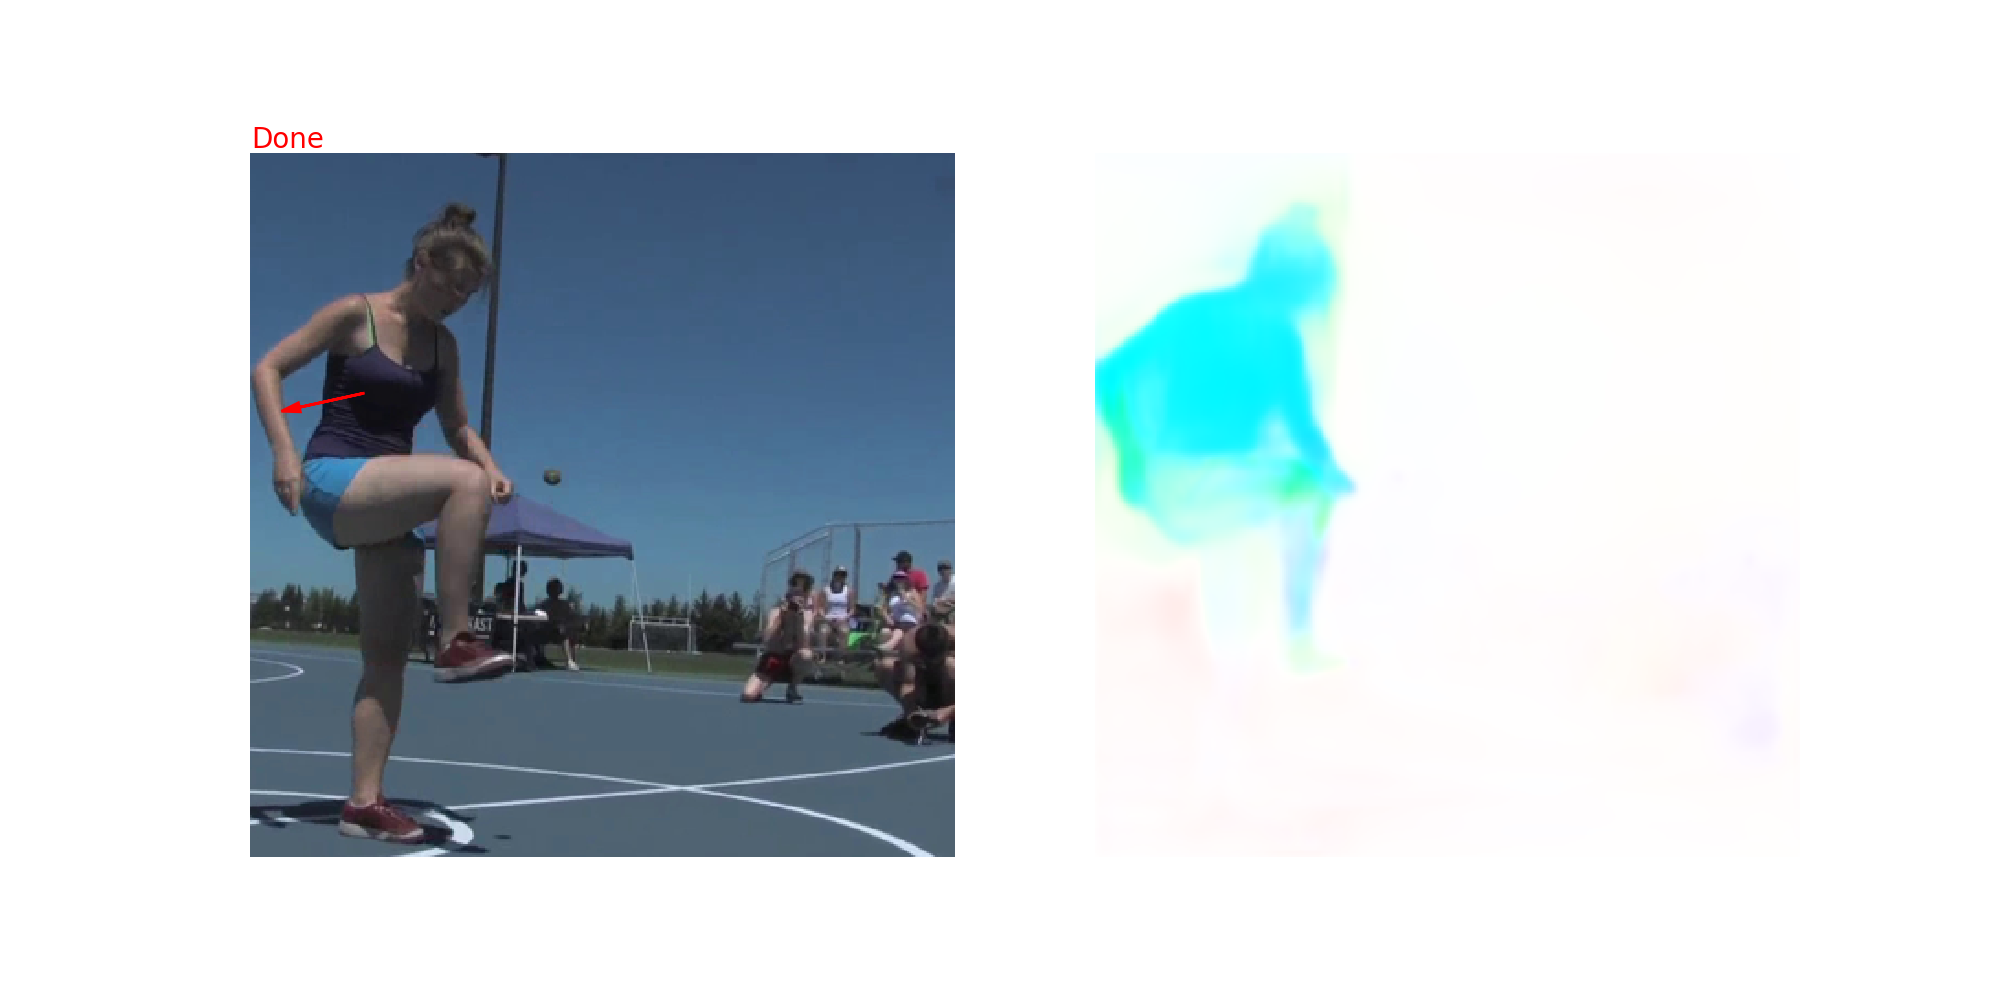

In [52]:
# Note:
# 1. run this cell, left click twice to draw an arrow, avoid clicking too close to edges of objects..
# 2. double click to draw a static point (guidance point with zero motion).
# 3. right click to remove a nearest arrow or static point.
# 3. press "e" to predict flow.
# 4. change "test_image_idx" to try other images.

source = 'example'

if source == 'example':
    fn = 'example_images/1.jpg' # 0.jpg, 1.jpg, 2.jpg
else:
    test_image_idx = 0 # [0,1000)
    target = 'MPII'

    with open('/home/xhzhan/Share/transfer/{}/list.txt'.format(target), 'r') as f:
        lines = f.readlines()
    fns = ['/home/xhzhan/Share/transfer/{}/'.format(target) + l.strip() for l in lines]
    fn = fns[test_image_idx]

img = Image.open(fn).convert("RGB")
obj.init_image(img)